<a href="https://colab.research.google.com/github/AndreaBertoglio/MLDM/blob/master/Neural_Network_GridSearch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NEURAL NETWORK

### Import

In [1]:
import csv
import pandas as pd 
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import numpy as np

import tensorflow as tf
# Import `Sequential` from `keras.models`
from keras.models import Sequential
# Import `Dense` from `keras.layers`
from keras.layers import Dense
# KerasClassifier necessario per GridSearch
from keras.wrappers.scikit_learn import KerasClassifier

# Import GridSearch
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

# Import confusion matrix and other
from sklearn.metrics import classification_report, confusion_matrix

### Preparazione dei dati

In [2]:
t= pd.read_csv('https://raw.githubusercontent.com/serivan/mldmlab/master/Datasets/Kaggle2020/train.csv')
t.to_csv('train.csv', index=False)

#sistemo CSV
with open('train.csv') as f_in, open('new_train.csv', 'w') as f_out:
    #crea il nuovo csv
    filewriter = csv.writer(f_out, delimiter=',')
    # Write header unchanged
    header = f_in.readline()
    f_out.write(header)

    reader = csv.reader(f_in)
    lines = list(reader)

    for line in lines:
        if line[2] != '' and float(line[2])>100:
            line[2]=float(line[2])/1000
        if line[8] != '' and float(line[8])>100:
            line[8]=float(line[8])/1000
    
    writer = csv.writer(f_out)
    writer.writerows(lines)

f_in.close()
f_out.close()


train = pd.read_csv('new_train.csv')
# pull data into target (y) and predictors (X)
train["Quality"] = np.where(train["Quality"].str.contains("Good"), 1, 0)
train_y = train.Quality
#tengo volatile e density perchè li ho sistemati
predictor_cols = ['fixed.acidity','volatile.acidity','citric.acid','residual.sugar','chlorides','free.sulfur.dioxide',
                  'total.sulfur.dioxide','density','pH','sulphates','alcohol']
# Create training predictors data
train_X = train[predictor_cols]

scaler = StandardScaler()

train_X_std = scaler.fit_transform(train_X)

# Create our imputer to replace missing values with the mean e.g.
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
#imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp = imp.fit(train_X_std)

# Impute our data, then train
train_X_imp = imp.transform(train_X_std)
print(train_X_imp.shape)

(3489, 11)


### Funzione di creazione del modello
createModel()

In [5]:
def createModel(hidden_layers=0, input_neurons=8, hidden_neurons=8, activation_fun='relu', _optimizer='SGD'):
  # Initialize the constructor
  model = Sequential()

  # Add an input layer 
  model.add(Dense(input_neurons, activation=activation_fun, input_shape=(11,)))

  # Add hidden layers
  for i in range(hidden_layers): 
    model.add(Dense(hidden_neurons, activation=activation_fun))

  # Add an output layer 
  model.add(Dense(1, activation='sigmoid'))   
  
  #Compile model
  model.compile(loss='binary_crossentropy',
              optimizer=_optimizer,
              metrics=['accuracy',tf.keras.metrics.AUC()])

  return model

### Preparazione della grid search

#### Parameter

In [ ]:
# epochs: numero di epoche per il train della rete
# batch_size: ogni quanto fare back propagation [maggiore o uguale a 1]
# input_neurons: quanti neuroni inserire nello strato di input [maggiore o uguale a 1]
# hidden_layers: numero di livelli nascosti (interni) [intero non negativo]
# hidden_neurons: quanti neuroni inserire negli strati interni [maggiore o uguale a 1]
#_optimizer: algoritmo di ottimizzazione usato ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
# activation_fun: funzione di attivazione dei neuroni ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']

In [4]:
parameter_grid = {'epochs': [15],
                  'batch_size': [1],
                  'input_neurons': [24],
                  'hidden_neurons': [8],
                  'hidden_layers': [1],
                  '_optimizer': ['SGD'],
                  'activation_fun': ['tanh']}



#Create the scoring dictionary
SCORING = {'f1': 'f1_macro',
          'accuracy': 'accuracy',
          'balanced_accuracy': 'balanced_accuracy',
          'precision': 'precision_macro',
          'recall': 'recall_macro'}

#### Cross validation

In [6]:
cross_validation = StratifiedKFold(n_splits=3)
cross_validation.get_n_splits(train_X_imp, train_y)

3

#### Grid search

In [7]:
model = KerasClassifier(build_fn=createModel, verbose=1)

#grid_search = GridSearchCV(model, param_grid=parameter_grid, cv=cross_validation, )
grid_search = GridSearchCV(model, param_grid=parameter_grid, cv=cross_validation, scoring=SCORING, return_train_score=True, refit='accuracy')

grid_search.fit(train_X_imp, train_y)

Epoch 1/15
2326/2326 [==============================] - 2s 879us/step - loss: 0.5239 - accuracy: 0.7279 - auc: 0.7857
Epoch 2/15
2326/2326 [==============================] - 2s 909us/step - loss: 0.5021 - accuracy: 0.7451 - auc: 0.8081
Epoch 3/15
2326/2326 [==============================] - 2s 834us/step - loss: 0.4896 - accuracy: 0.7623 - auc: 0.8199
Epoch 4/15
2326/2326 [==============================] - 2s 869us/step - loss: 0.4796 - accuracy: 0.7678 - auc: 0.8283
Epoch 5/15
2326/2326 [==============================] - 2s 816us/step - loss: 0.4739 - accuracy: 0.7627 - auc: 0.8319
Epoch 6/15
2326/2326 [==============================] - 2s 837us/step - loss: 0.4679 - accuracy: 0.7743 - auc: 0.8369
Epoch 7/15
2326/2326 [==============================] - 2s 884us/step - loss: 0.4643 - accuracy: 0.7721 - auc: 0.8400
Epoch 8/15
2326/2326 [==============================] - 2s 800us/step - loss: 0.4598 - accuracy: 0.7799 - auc: 0.8440
Epoch 9/15
2326/2326 [==============================] - 

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             error_score=nan,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7f5b4a57de80>,
             iid='deprecated', n_jobs=None,
             param_grid={'_optimizer': ['SGD'], 'activation_fun': ['tanh'],
                         'batch_size': [1], 'epochs': [15],
                         'hidden_layers': [1], 'hidden_neurons': [8],
                         'input_neurons': [24]},
             pre_dispatch='2*n_jobs', refit='accuracy', return_train_score=True,
             scoring={'accuracy': 'accuracy',
                      'balanced_accuracy': 'balanced_accuracy',
                      'f1': 'f1_macro', 'precision': 'precision_macro',
                      'recall': 'recall_macro'},
             verbose=0)

## Risultati GridSearch

### Generale

In [8]:
grid_search.cv_results_

{'mean_fit_time': array([30.33271106]),
 'mean_score_time': array([0.75352526]),
 'mean_test_accuracy': array([0.75465749]),
 'mean_test_balanced_accuracy': array([0.71975099]),
 'mean_test_f1': array([0.72229164]),
 'mean_test_precision': array([0.73159429]),
 'mean_test_recall': array([0.71975099]),
 'mean_train_accuracy': array([0.80252221]),
 'mean_train_balanced_accuracy': array([0.77211384]),
 'mean_train_f1': array([0.77695119]),
 'mean_train_precision': array([0.78619607]),
 'mean_train_recall': array([0.77211384]),
 'param__optimizer': masked_array(data=['SGD'],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_activation_fun': masked_array(data=['tanh'],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_batch_size': masked_array(data=[1],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_epochs': masked_array(data=[15],
              mask=[False],
        fill_val

### Combinazione migliore

In [9]:
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

best_dtc = grid_search.best_estimator_
best_dtc

Best score: 0.7546574949842362
Best parameters: {'_optimizer': 'SGD', 'activation_fun': 'tanh', 'batch_size': 1, 'epochs': 15, 'hidden_layers': 1, 'hidden_neurons': 8, 'input_neurons': 24}


## Training finale

In [10]:
my_model=best_dtc
training_phase = my_model.fit(train_X_imp, train_y)

Epoch 1/15
3489/3489 [==============================] - 3s 817us/step - loss: 0.5263 - accuracy: 0.7300 - auc_4: 0.7822
Epoch 2/15
3489/3489 [==============================] - 3s 861us/step - loss: 0.5032 - accuracy: 0.7492 - auc_4: 0.8064
Epoch 3/15
3489/3489 [==============================] - 3s 814us/step - loss: 0.4936 - accuracy: 0.7547 - auc_4: 0.8148
Epoch 4/15
3489/3489 [==============================] - 3s 848us/step - loss: 0.4882 - accuracy: 0.7595 - auc_4: 0.8198
Epoch 5/15
3489/3489 [==============================] - 3s 822us/step - loss: 0.4809 - accuracy: 0.7644 - auc_4: 0.8268
Epoch 6/15
3489/3489 [==============================] - 3s 819us/step - loss: 0.4753 - accuracy: 0.7664 - auc_4: 0.8314
Epoch 7/15
3489/3489 [==============================] - 3s 826us/step - loss: 0.4716 - accuracy: 0.7756 - auc_4: 0.8343
Epoch 8/15
3489/3489 [==============================] - 3s 841us/step - loss: 0.4666 - accuracy: 0.7756 - auc_4: 0.8386
Epoch 9/15
3489/3489 [==================

### Scoring

In [11]:
my_model.score(train_X_imp, train_y)

3489/3489 [==============================] - 3s 841us/step - loss: 0.4255 - accuracy: 0.7994 - auc_4: 0.8715


0.7993694543838501

loss


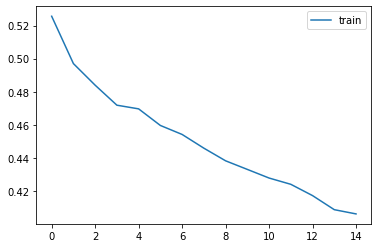

Accuracy


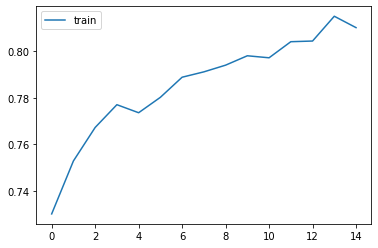

In [ ]:
import matplotlib.pyplot as pyplot
    
# plot training history
print("loss")
pyplot.plot(training_phase.history['loss'], label='train')
#pyplot.plot(training_phase.history['val_loss'], label='validation')
pyplot.legend()
pyplot.show()

print("Accuracy")
pyplot.plot(training_phase.history['accuracy'], label='train')
#pyplot.plot(training_phase.history['val_accuracy'], label='validation')
pyplot.legend()
pyplot.show()

### Confusion matrix

In [ ]:
y_pred = my_model.predict(train_X_imp)
print("Confusion Matrix:")
print(confusion_matrix(train_y, y_pred))

print("Classification Report:")
print(classification_report(train_y, y_pred))

3489/3489 [==============================] - 1s 342us/step
Confusion Matrix:
[[ 826  379]
 [ 222 2062]]
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.69      0.73      1205
           1       0.84      0.90      0.87      2284

    accuracy                           0.83      3489
   macro avg       0.82      0.79      0.80      3489
weighted avg       0.83      0.83      0.82      3489



## Test e Submission

In [ ]:
#TEST SET
t= pd.read_csv('https://raw.githubusercontent.com/serivan/mldmlab/master/Datasets/Kaggle2020/test.csv')
t.to_csv('test.csv', index=False)

#sistemo csv
with open('test.csv') as f_in, open('new_test.csv', 'w') as f_out:
    #crea il nuovo csv
    filewriter = csv.writer(f_out, delimiter=',')
    # Write header unchanged
    header = f_in.readline()
    f_out.write(header)

    reader = csv.reader(f_in)
    lines = list(reader)

    for line in lines:
        if line[2] != '' and float(line[2])>100:
            line[2]=float(line[2])/1000
        if line[8] != '' and float(line[8])>100:
            line[8]=float(line[8])/1000

    writer = csv.writer(f_out)
    writer.writerows(lines)

f_in.close()
f_out.close()

test = pd.read_csv('new_test.csv')
# Treat the test data in the same way as training data. In this case, pull same columns.
test_X = test[predictor_cols]

test_X_std = scaler.transform(test_X)

# Impute each test item, then predict
test_X_imp = imp.transform(test_X_std)

# Use the model to make predictions
predicted_q = my_model.predict(test_X_imp)
# We will look at the predicted Qualities to ensure we have something sensible.
predicted_q = [round(x[0]) for x in predicted_q]

for i in range (0,len(predicted_q)):
    predicted_q[i]=int(predicted_q[i])

print(predicted_q)


1164/1164 [==============================] - 0s 339us/step
[1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1

### Generazione file di submission

In [ ]:

#prepare kaggle submission
my_submission = pd.DataFrame({'Id': test.Id, 'Quality': predicted_q})
# you could use any filename. We choose submission here
my_submission.to_csv('submission.csv', index=False)